In [2]:
import numpy as np
import pandas as pd
import zipfile

In [3]:
# Import dataset from zip file
df1 = pd.read_csv('archive (1).zip', compression='zip')
df1

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Precious Achiuwa,C-PF,24,TOT,26,0,17.2,3.0,6.6,0.453,...,0.571,2.0,3.4,5.3,1.7,0.6,0.5,1.1,1.6,7.4
1,Precious Achiuwa,C,24,TOR,25,0,17.5,3.1,6.8,0.459,...,0.571,2.0,3.4,5.4,1.8,0.6,0.5,1.2,1.6,7.7
2,Precious Achiuwa,PF,24,NYK,1,0,9.0,0.0,2.0,0.000,...,NaN,1.0,2.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0
3,Bam Adebayo,C,26,MIA,23,23,34.1,8.0,15.7,0.506,...,0.777,2.1,8.3,10.4,4.0,1.1,1.0,2.7,2.4,22.0
4,Ochai Agbaji,SG,23,UTA,34,10,21.1,2.6,5.7,0.451,...,0.714,0.8,1.7,2.5,1.0,0.6,0.5,0.7,1.5,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,Thaddeus Young,PF,35,TOR,7,0,4.4,0.9,1.4,0.600,...,0.333,0.4,0.6,1.0,1.0,0.3,0.0,0.6,0.4,1.9
534,Trae Young,PG,25,ATL,30,30,36.6,8.8,20.2,0.436,...,0.860,0.5,2.5,3.0,11.3,1.4,0.2,4.3,2.0,28.3
535,Omer Yurtseven,C,25,UTA,20,6,11.7,1.8,3.5,0.507,...,0.750,1.5,2.9,4.4,0.7,0.2,0.5,1.0,1.6,4.0
536,Cody Zeller,C,31,NOP,23,0,9.6,0.6,1.7,0.333,...,0.577,1.2,1.8,3.0,1.1,0.2,0.1,0.3,1.3,1.8


In [4]:
# Clean dataset by removing duplicates, players playing under 8 minutes per game, and player that played in less than 60% of available games
duplicates = df1.duplicated(subset=['Player'], keep=False)
df1_sorted = df1.sort_values(by='Player', ascending=False)
df1_dedup = df1_sorted[~duplicates]
result = df1_dedup.drop_duplicates(subset=['Player'])
result

/tmp/ipykernel_1073/3859694163.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1_dedup = df1_sorted[~duplicates]


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
527,Zion Williamson,PF,23,NOP,27,27,30.9,8.8,15.1,0.582,...,0.656,2.0,4.2,6.1,4.6,1.0,0.3,2.6,2.7,22.4
526,Ziaire Williams,SF,22,MEM,30,8,19.0,2.5,6.6,0.382,...,0.854,0.6,3.0,3.6,1.4,0.4,0.3,1.3,1.7,7.3
351,Zeke Nnaji,PF,23,DEN,29,0,10.4,1.3,2.7,0.474,...,0.629,1.2,1.1,2.4,0.5,0.2,0.7,0.7,1.6,3.4
266,Zach LaVine,SG,28,CHI,18,18,35.3,7.3,16.6,0.443,...,0.866,0.3,4.6,4.9,3.4,0.9,0.2,2.0,2.1,21.0
102,Zach Collins,C,26,SAS,31,23,26.1,4.9,10.0,0.495,...,0.792,1.9,4.1,6.0,3.3,0.6,0.8,2.3,3.4,12.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Aaron Holiday,PG,27,HOU,29,1,18.1,2.6,5.9,0.439,...,0.895,0.3,1.7,2.0,1.8,0.5,0.1,0.8,1.7,7.1
167,Aaron Gordon,PF,28,DEN,29,29,31.7,5.5,10.3,0.530,...,0.604,2.8,3.9,6.7,3.3,1.0,0.6,1.4,1.6,13.4
177,AJ Griffin,SF,20,ATL,12,0,9.2,0.8,2.8,0.294,...,1.000,0.2,0.8,1.0,0.3,0.1,0.0,0.3,0.5,2.5
267,A.J. Lawson,SG,23,DAL,13,0,9.8,1.7,3.4,0.500,...,0.625,0.5,0.8,1.2,0.5,0.5,0.1,0.5,0.5,4.3


In [5]:
df1 = df1[df1['MP'] >= 8]
max_value_games = df1['G'].max()
threshold = 0.6 * max_value_games
df1 = df1[df1['G'] >= threshold]
df1.drop(1, inplace=True)
df1
# This cleaning cut my dataset from 528 rows to 286 rows

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Precious Achiuwa,C-PF,24,TOT,26,0,17.2,3.0,6.6,0.453,...,0.571,2.0,3.4,5.3,1.7,0.6,0.5,1.1,1.6,7.4
3,Bam Adebayo,C,26,MIA,23,23,34.1,8.0,15.7,0.506,...,0.777,2.1,8.3,10.4,4.0,1.1,1.0,2.7,2.4,22.0
4,Ochai Agbaji,SG,23,UTA,34,10,21.1,2.6,5.7,0.451,...,0.714,0.8,1.7,2.5,1.0,0.6,0.5,0.7,1.5,6.6
5,Santi Aldama,PF,23,MEM,25,5,24.0,4.2,9.5,0.443,...,0.590,1.3,4.0,5.4,1.8,0.6,0.7,1.0,1.6,11.0
6,Nickeil Alexander-Walker,SG,25,MIN,32,11,22.6,2.4,5.8,0.418,...,0.647,0.4,1.3,1.8,2.4,0.9,0.6,1.0,1.9,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,James Wiseman,C,22,DET,22,0,14.2,2.8,3.9,0.721,...,0.654,1.4,2.8,4.1,0.6,0.2,0.7,1.0,2.2,6.4
531,Christian Wood,PF,28,LAL,29,1,19.0,2.4,5.1,0.466,...,0.614,0.8,4.6,5.4,1.0,0.2,0.6,1.2,1.5,6.8
534,Trae Young,PG,25,ATL,30,30,36.6,8.8,20.2,0.436,...,0.860,0.5,2.5,3.0,11.3,1.4,0.2,4.3,2.0,28.3
536,Cody Zeller,C,31,NOP,23,0,9.6,0.6,1.7,0.333,...,0.577,1.2,1.8,3.0,1.1,0.2,0.1,0.3,1.3,1.8


In [6]:
# I wanted to change to PTS column to PPG to make it more clear
df1 = df1.rename(columns={'PTS': 'PPG'})
df1

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG
0,Precious Achiuwa,C-PF,24,TOT,26,0,17.2,3.0,6.6,0.453,...,0.571,2.0,3.4,5.3,1.7,0.6,0.5,1.1,1.6,7.4
3,Bam Adebayo,C,26,MIA,23,23,34.1,8.0,15.7,0.506,...,0.777,2.1,8.3,10.4,4.0,1.1,1.0,2.7,2.4,22.0
4,Ochai Agbaji,SG,23,UTA,34,10,21.1,2.6,5.7,0.451,...,0.714,0.8,1.7,2.5,1.0,0.6,0.5,0.7,1.5,6.6
5,Santi Aldama,PF,23,MEM,25,5,24.0,4.2,9.5,0.443,...,0.590,1.3,4.0,5.4,1.8,0.6,0.7,1.0,1.6,11.0
6,Nickeil Alexander-Walker,SG,25,MIN,32,11,22.6,2.4,5.8,0.418,...,0.647,0.4,1.3,1.8,2.4,0.9,0.6,1.0,1.9,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,James Wiseman,C,22,DET,22,0,14.2,2.8,3.9,0.721,...,0.654,1.4,2.8,4.1,0.6,0.2,0.7,1.0,2.2,6.4
531,Christian Wood,PF,28,LAL,29,1,19.0,2.4,5.1,0.466,...,0.614,0.8,4.6,5.4,1.0,0.2,0.6,1.2,1.5,6.8
534,Trae Young,PG,25,ATL,30,30,36.6,8.8,20.2,0.436,...,0.860,0.5,2.5,3.0,11.3,1.4,0.2,4.3,2.0,28.3
536,Cody Zeller,C,31,NOP,23,0,9.6,0.6,1.7,0.333,...,0.577,1.2,1.8,3.0,1.1,0.2,0.1,0.3,1.3,1.8


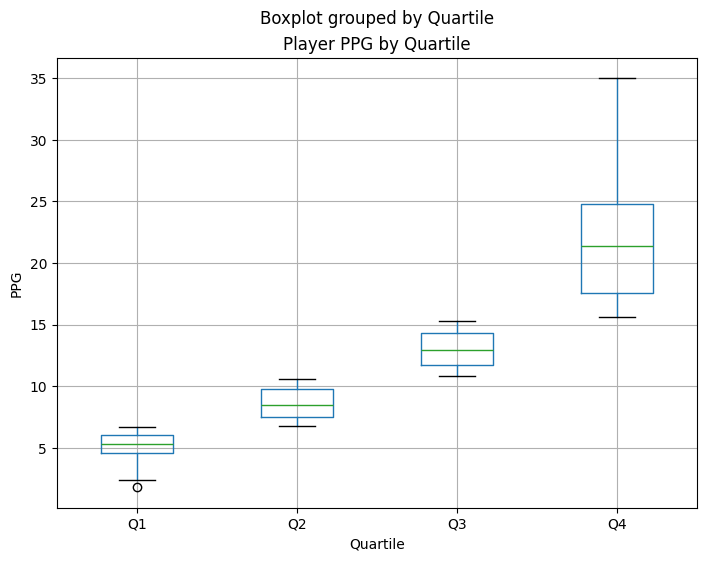

In [7]:
# Now let's do some analysis on player's points per game and efficiency
# First, I want to split the PPG column into quartiles to see the range of PPG in each quartile
import matplotlib.pyplot as plt
quartiles = df1['PPG'].quantile([0.25, 0.5, 0.75])
df1['Quartile'] = pd.qcut(df1['PPG'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
plt.figure(figsize=(8, 6))
df1.boxplot(column='PPG', by='Quartile', ax=plt.gca())
plt.title('Player PPG by Quartile')
plt.ylabel('PPG')
plt.xlabel('Quartile')
plt.show()

In [8]:
# Next, I want to see the top 10 scorers in the NBA
sorted_df = df1.sort_values(by='PPG', ascending=False)
sorted_df.head(10)
# This tells me Joel Embiid, for Philadelphia, leads the NBA in ppg with 35; there are also 5 players averaging at least 30 ppg

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,Quartile
137,Joel Embiid,C,29,PHI,25,25,34.2,11.8,21.8,0.540,...,2.8,8.9,11.7,6.0,1.2,2.0,3.8,2.8,35.0,Q4
125,Luka Dončić,PG,24,DAL,31,31,36.9,11.4,23.6,0.484,...,0.8,7.5,8.3,9.4,1.4,0.6,4.0,1.7,33.4,Q4
161,Shai Gilgeous-Alexander,PG,25,OKC,30,30,34.7,11.2,20.6,0.546,...,0.8,4.8,5.7,6.3,2.6,0.8,2.0,2.3,31.2,Q4
11,Giannis Antetokounmpo,PF,29,MIL,32,32,34.8,11.5,18.9,0.606,...,2.7,8.6,11.3,5.7,1.3,1.2,3.8,2.9,30.9,Q4
147,De'Aaron Fox,PG,26,SAC,25,25,35.3,10.5,21.8,0.483,...,1.0,3.6,4.6,6.1,1.6,0.4,2.6,2.7,30.0,Q4
131,Kevin Durant,PF,35,PHO,28,28,37.1,10.4,19.7,0.525,...,0.4,5.9,6.3,6.0,0.9,1.1,3.4,1.8,29.9,Q4
534,Trae Young,PG,25,ATL,30,30,36.6,8.8,20.2,0.436,...,0.5,2.5,3.0,11.3,1.4,0.2,4.3,2.0,28.3,Q4
329,Donovan Mitchell,SG,27,CLE,24,24,36.5,9.8,21.3,0.457,...,1.1,4.6,5.7,5.7,1.9,0.5,2.6,2.4,27.9,Q4
113,Stephen Curry,PG,35,GSW,30,30,33.5,8.6,19.0,0.453,...,0.5,3.9,4.4,4.5,0.7,0.4,3.1,1.8,27.3,Q4
459,Jayson Tatum,PF,25,BOS,30,30,36.8,9.3,19.6,0.474,...,0.9,7.5,8.4,4.4,1.0,0.5,2.9,2.1,26.9,Q4


In [9]:
# Now, I want to see efficiency, so I'm going to group by PPG and eFG%
grouped = df1.groupby(['eFG%', 'PPG']).agg({'eFG%': 'max'})
grouped

,,eFG%
eFG%,PPG,
0.333,1.8,0.333
0.396,2.8,0.396
0.419,12.4,0.419
0.425,5.3,0.425
0.435,3.8,0.435
...,...,...
0.702,9.0,0.702
0.719,5.8,0.719
0.721,6.4,0.721


In [10]:
df1['eFG%'].mean()

0.5500769230769231

In [11]:
grouped2 = df1.groupby(['PPG', 'eFG%']).agg({'PPG': 'max'})
grouped2
# As you can see, the players that have the highest eFG% typically don't score as much because they're taking less shots, but the highest scorers are usually a little above average in their eFG%

,,PPG
PPG,eFG%,
1.8,0.333,1.8
2.4,0.649,2.4
2.5,0.509,2.5
2.8,0.396,2.8
3.0,0.655,3.0
...,...,...
30.0,0.565,30.0
30.9,0.615,30.9
31.2,0.572,31.2


In [12]:
# I want to see the top 10 most efficient scorers that average at least 10 ppg
at_least_10ppg = df1[df1['PPG'] > 10]
at_least_10ppg.sort_values(by='eFG%', ascending=False).head(10)
# You can see a dominant trend that Cs and PFs are more efficient, thanks to most of their shots coming right at the rim

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,Quartile
376,Jakob Poeltl,C,28,TOR,33,33,26.3,4.7,6.8,0.695,...,2.8,5.5,8.3,2.4,0.7,1.3,1.5,2.8,10.5,Q2
150,Daniel Gafford,C,25,WAS,29,29,25.7,4.4,6.4,0.684,...,2.8,4.9,7.7,1.6,0.9,2.2,1.1,3.4,10.8,Q3
8,Jarrett Allen,C,25,CLE,28,28,30.0,6.0,8.9,0.671,...,3.2,6.1,9.3,2.8,0.8,0.9,1.7,2.6,14.4,Q3
475,Obi Toppin,PF,25,IND,32,27,23.9,4.6,7.8,0.586,...,1.1,2.8,3.9,1.3,0.5,0.6,0.8,2.2,11.5,Q3
43,Malik Beasley,SG,27,MIL,31,31,29.9,4.3,8.7,0.487,...,0.7,3.6,4.3,1.4,0.8,0.1,0.6,2.0,11.8,Q3
348,Aaron Nesmith,SF,24,IND,30,5,25.6,4.2,8.1,0.514,...,0.9,2.4,3.2,1.0,1.1,0.8,0.9,3.4,11.7,Q3
537,Ivica Zubac,C,26,LAC,32,32,26.9,5.3,8.2,0.644,...,3.2,6.5,9.7,1.2,0.2,1.3,1.2,2.8,12.2,Q3
7,Grayson Allen,SG,28,PHO,28,28,33.2,4.5,8.8,0.506,...,0.9,3.5,4.3,2.8,1.0,0.6,1.4,2.2,13.1,Q3
495,Moritz Wagner,C,26,ORL,32,0,18.5,4.4,7.3,0.601,...,1.5,2.8,4.4,1.2,0.4,0.3,1.3,2.3,11.2,Q3
124,Donte DiVincenzo,SG,27,NYK,33,15,21.3,3.7,7.9,0.469,...,0.7,2.2,2.9,1.8,1.1,0.3,1.0,1.8,10.6,Q2


In [13]:
# Let's take a look at rebounds and assists
df1.sort_values(by='TRB', ascending=False).head(10)
# Centers and PFs lead this category nearly every year, so I want to see the best rebounding PGs

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,Quartile
418,Domantas Sabonis,C,27,SAC,31,31,34.7,7.6,12.9,0.593,...,3.2,9.1,12.3,7.5,0.8,0.6,2.9,3.2,19.4,Q4
115,Anthony Davis,C,30,LAL,32,32,35.6,9.5,17.2,0.551,...,3.3,9.0,12.3,3.3,1.2,2.6,2.0,2.6,25.0,Q4
242,Nikola Jokić,C,28,DEN,34,34,33.4,9.9,17.8,0.559,...,3.0,9.2,12.3,9.1,1.1,0.9,2.7,2.6,25.7,Q4
165,Rudy Gobert,C,31,MIN,32,32,32.7,4.9,7.9,0.619,...,3.5,8.6,12.1,1.2,0.7,2.1,1.6,2.8,12.8,Q3
137,Joel Embiid,C,29,PHI,25,25,34.2,11.8,21.8,0.540,...,2.8,8.9,11.7,6.0,1.2,2.0,3.8,2.8,35.0,Q4
11,Giannis Antetokounmpo,PF,29,MIL,32,32,34.8,11.5,18.9,0.606,...,2.7,8.6,11.3,5.7,1.3,1.2,3.8,2.9,30.9,Q4
19,Deandre Ayton,C,25,POR,24,24,31.7,6.0,10.9,0.548,...,3.4,7.3,10.8,1.6,1.2,0.7,2.1,2.5,13.1,Q3
88,Clint Capela,C,29,ATL,31,31,26.3,5.0,8.5,0.591,...,4.9,5.8,10.7,1.2,0.6,1.6,1.0,2.7,12.0,Q3
330,Evan Mobley,PF,22,CLE,21,21,33.6,6.8,11.8,0.573,...,2.7,7.8,10.5,2.9,0.8,1.7,2.3,2.9,16.0,Q4
354,Jusuf Nurkić,C,29,PHO,31,31,28.0,4.8,9.8,0.485,...,2.8,7.5,10.4,3.6,0.9,1.2,2.1,3.5,12.8,Q3


In [14]:
guards = df1[df1['Pos'] == 'PG']
guards.sort_values(by='TRB', ascending=False).head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,Quartile
125,Luka Dončić,PG,24,DAL,31,31,36.9,11.4,23.6,0.484,...,0.8,7.5,8.3,9.4,1.4,0.6,4.0,1.7,33.4,Q4
206,Jrue Holiday,PG,33,BOS,29,29,34.7,5.0,10.9,0.459,...,1.7,4.9,6.6,4.7,0.9,0.8,2.0,1.7,13.1,Q3
509,Russell Westbrook,PG,35,LAC,32,10,23.9,4.6,9.9,0.468,...,1.6,4.9,6.5,4.7,1.1,0.5,2.3,2.0,11.4,Q3
161,Shai Gilgeous-Alexander,PG,25,OKC,30,30,34.7,11.2,20.6,0.546,...,0.8,4.8,5.7,6.3,2.6,0.8,2.0,2.3,31.2,Q4
58,Devin Booker,PG,27,PHO,24,24,35.8,8.9,19.1,0.466,...,0.9,4.4,5.3,7.9,0.8,0.4,2.8,3.3,26.4,Q4
184,James Harden,PG,34,LAC,27,27,34.0,5.2,11.1,0.467,...,0.3,4.4,4.8,8.0,1.4,1.0,2.6,2.1,17.6,Q4
147,De'Aaron Fox,PG,26,SAC,25,25,35.3,10.5,21.8,0.483,...,1.0,3.6,4.6,6.1,1.6,0.4,2.6,2.7,30.0,Q4
275,Damian Lillard,PG,33,MIL,31,31,35.2,7.4,17.1,0.431,...,0.6,3.9,4.5,6.8,1.0,0.2,2.7,1.7,25.5,Q4
13,Cole Anthony,PG,23,ORL,32,0,24.9,4.8,10.8,0.448,...,1.1,3.3,4.4,3.5,0.8,0.4,1.8,2.7,14.3,Q3
113,Stephen Curry,PG,35,GSW,30,30,33.5,8.6,19.0,0.453,...,0.5,3.9,4.4,4.5,0.7,0.4,3.1,1.8,27.3,Q4


In [15]:
df1.sort_values(by="AST", ascending=False).head(10)
# The assist category shows the best passers in the league; PGs, Cs, and PFs are represented in this category

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,Quartile
181,Tyrese Haliburton,PG,23,IND,29,29,34.3,8.8,17.6,0.501,...,0.7,3.5,4.2,12.7,1.0,0.6,2.6,1.1,24.7,Q4
534,Trae Young,PG,25,ATL,30,30,36.6,8.8,20.2,0.436,...,0.5,2.5,3.0,11.3,1.4,0.2,4.3,2.0,28.3,Q4
125,Luka Dončić,PG,24,DAL,31,31,36.9,11.4,23.6,0.484,...,0.8,7.5,8.3,9.4,1.4,0.6,4.0,1.7,33.4,Q4
242,Nikola Jokić,C,28,DEN,34,34,33.4,9.9,17.8,0.559,...,3.0,9.2,12.3,9.1,1.1,0.9,2.7,2.6,25.7,Q4
488,Fred VanVleet,PG,29,HOU,30,30,37.4,5.7,14.2,0.402,...,0.3,3.6,3.9,8.5,1.1,0.5,1.7,1.9,17.4,Q4
184,James Harden,PG,34,LAC,27,27,34.0,5.2,11.1,0.467,...,0.3,4.4,4.8,8.0,1.4,1.0,2.6,2.1,17.6,Q4
58,Devin Booker,PG,27,PHO,24,24,35.8,8.9,19.1,0.466,...,0.9,4.4,5.3,7.9,0.8,0.4,2.8,3.3,26.4,Q4
418,Domantas Sabonis,C,27,SAC,31,31,34.7,7.6,12.9,0.593,...,3.2,9.1,12.3,7.5,0.8,0.6,2.9,3.2,19.4,Q4
231,LeBron James,PF,39,LAL,31,31,34.2,9.4,17.6,0.535,...,0.9,6.5,7.4,7.4,1.4,0.7,3.3,1.1,25.4,Q4
365,Chris Paul,PG,38,GSW,29,8,27.5,3.2,7.9,0.412,...,0.3,3.4,3.8,7.4,1.2,0.1,1.2,1.9,8.9,Q2


In [16]:
# Assist to turnover ratio is a very sought after statistic, but this dataset does not have it, so I'm going to create a column for it
assist_to_turnover = df1['AST'] / df1['TOV']
df1['assist_to_turnover'] = assist_to_turnover
df1.sort_values(by='assist_to_turnover', ascending=False).head(10)
# I did not expect Kenrich Williams to be this high, but it makes sense due to his low touches

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,Quartile,assist_to_turnover
521,Kenrich Williams,PF,29,OKC,21,0,15.7,2.0,4.0,0.494,...,2.0,2.7,1.7,0.6,0.1,0.2,1.6,5.0,Q1,8.500000
248,Tyus Jones,PG,27,WAS,32,32,28.0,5.3,9.8,0.537,...,2.7,3.0,5.5,1.2,0.3,0.8,0.8,12.6,Q3,6.875000
365,Chris Paul,PG,38,GSW,29,8,27.5,3.2,7.9,0.412,...,3.4,3.8,7.4,1.2,0.1,1.2,1.9,8.9,Q2,6.166667
103,Mike Conley,PG,36,MIN,32,32,29.4,3.8,8.3,0.461,...,2.5,2.8,6.2,1.0,0.2,1.1,1.7,11.5,Q3,5.636364
389,Payton Pritchard,PG,26,BOS,32,0,20.5,2.7,6.5,0.413,...,2.2,3.2,3.0,0.4,0.1,0.6,1.3,7.4,Q2,5.000000
488,Fred VanVleet,PG,29,HOU,30,30,37.4,5.7,14.2,0.402,...,3.6,3.9,8.5,1.1,0.5,1.7,1.9,17.4,Q4,5.000000
181,Tyrese Haliburton,PG,23,IND,29,29,34.3,8.8,17.6,0.501,...,3.5,4.2,12.7,1.0,0.6,2.6,1.1,24.7,Q4,4.884615
307,T.J. McConnell,PG,31,IND,24,1,15.1,3.3,6.3,0.527,...,2.0,2.6,4.8,0.9,0.1,1.1,1.0,7.6,Q2,4.363636
216,Kevin Huerter,SG,25,SAC,30,29,24.2,3.9,9.2,0.428,...,3.1,3.7,2.6,0.6,0.3,0.6,2.2,10.4,Q2,4.333333
303,Tyrese Maxey,PG,23,PHI,31,31,37.4,9.0,19.7,0.458,...,3.2,3.8,6.5,0.8,0.5,1.5,2.1,26.1,Q4,4.333333


In [17]:
# In basketball, steals and blocks are often combined to be called stocks. I want to analyze stocks to see defensive value
df1['Stocks'] = df1[['STL', 'BLK']].sum(axis=1)
df1.sort_values(by='Stocks', ascending=False).head(10)



,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,TRB,AST,STL,BLK,TOV,PF,PPG,Quartile,assist_to_turnover,Stocks
507,Victor Wembanyama,PF,20,SAS,28,28,29.5,7.0,15.8,0.442,...,10.3,3.0,1.3,3.1,3.3,2.3,18.9,Q4,0.909091,4.4
115,Anthony Davis,C,30,LAL,32,32,35.6,9.5,17.2,0.551,...,12.3,3.3,1.2,2.6,2.0,2.6,25.0,Q4,1.650000,3.8
282,Brook Lopez,C,35,MIL,33,33,31.1,4.8,9.9,0.479,...,5.1,1.4,0.7,3.1,0.8,2.8,12.8,Q3,1.750000,3.8
209,Chet Holmgren,C,21,OKC,31,31,29.9,6.5,12.0,0.543,...,7.8,2.5,0.7,2.7,1.8,2.7,17.7,Q4,1.388889,3.4
161,Shai Gilgeous-Alexander,PG,25,OKC,30,30,34.7,11.2,20.6,0.546,...,5.7,6.3,2.6,0.8,2.0,2.3,31.2,Q4,3.150000,3.4
137,Joel Embiid,C,29,PHI,25,25,34.2,11.8,21.8,0.540,...,11.7,6.0,1.2,2.0,3.8,2.8,35.0,Q4,1.578947,3.2
254,Walker Kessler,C,22,UTA,26,13,25.0,4.1,6.7,0.618,...,8.1,0.8,0.5,2.7,1.2,2.0,9.0,Q2,0.666667,3.2
150,Daniel Gafford,C,25,WAS,29,29,25.7,4.4,6.4,0.684,...,7.7,1.6,0.9,2.2,1.1,3.4,10.8,Q3,1.454545,3.1
98,Nic Claxton,C,24,BRK,23,23,27.7,5.0,8.1,0.618,...,9.9,1.8,0.4,2.5,0.9,2.4,11.7,Q3,2.000000,2.9
32,Scottie Barnes,SG,22,TOR,33,33,35.2,7.8,16.3,0.480,...,9.3,5.8,1.5,1.4,2.4,2.0,21.0,Q4,2.416667,2.9


In [18]:
# Now I want to see the highest stocks by the age of each player
young_stocks = df1.groupby(df1['Age']).agg({'Stocks': 'max'})
young_stocks

,Stocks
Age,
19,2.0
20,4.4
21,3.4
22,3.2
23,1.6
24,2.9
25,3.4
26,2.6
27,2.7


In [19]:
young_stocks.max() , young_stocks.idxmax()
# We see that the max stocks is 4.4 by a 20 year old!

(Stocks    4.4
 dtype: float64,
 Stocks    20
 dtype: int64)

In [20]:
young_stocks_avg = df1.groupby(df1['Age']).agg({'Stocks': 'mean'})
young_stocks_avg


,Stocks
Age,
19,1.466667
20,1.336364
21,1.042857
22,1.545455
23,1.092857
24,1.287500
25,1.496296
26,1.409091
27,1.377273


In [20]:
# Finally, I want to see what players average the most points, assists, rebounds, blocks, and steals - the 5 major stats in basketball - combined.
df1['5_Stats'] = df1[['STL', 'BLK', 'PPG', 'TRB', 'AST']].sum(axis=1)
df1['5_Stats'].mean()

20.723076923076924

In [21]:
all_around_hoopers = df1.sort_values(by='5_Stats', ascending=False).head(10)
all_around_hoopers

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PPG,Quartile,assist_to_turnover,Stocks,5_Stats
137,Joel Embiid,C,29,PHI,25,25,34.2,11.8,21.8,0.540,...,6.0,1.2,2.0,3.8,2.8,35.0,Q4,1.578947,3.2,55.9
125,Luka Dončić,PG,24,DAL,31,31,36.9,11.4,23.6,0.484,...,9.4,1.4,0.6,4.0,1.7,33.4,Q4,2.350000,2.0,53.1
11,Giannis Antetokounmpo,PF,29,MIL,32,32,34.8,11.5,18.9,0.606,...,5.7,1.3,1.2,3.8,2.9,30.9,Q4,1.500000,2.5,50.4
242,Nikola Jokić,C,28,DEN,34,34,33.4,9.9,17.8,0.559,...,9.1,1.1,0.9,2.7,2.6,25.7,Q4,3.370370,2.0,49.1
161,Shai Gilgeous-Alexander,PG,25,OKC,30,30,34.7,11.2,20.6,0.546,...,6.3,2.6,0.8,2.0,2.3,31.2,Q4,3.150000,3.4,46.6
115,Anthony Davis,C,30,LAL,32,32,35.6,9.5,17.2,0.551,...,3.3,1.2,2.6,2.0,2.6,25.0,Q4,1.650000,3.8,44.4
534,Trae Young,PG,25,ATL,30,30,36.6,8.8,20.2,0.436,...,11.3,1.4,0.2,4.3,2.0,28.3,Q4,2.627907,1.6,44.2
131,Kevin Durant,PF,35,PHO,28,28,37.1,10.4,19.7,0.525,...,6.0,0.9,1.1,3.4,1.8,29.9,Q4,1.764706,2.0,44.2
181,Tyrese Haliburton,PG,23,IND,29,29,34.3,8.8,17.6,0.501,...,12.7,1.0,0.6,2.6,1.1,24.7,Q4,4.884615,1.6,43.2
147,De'Aaron Fox,PG,26,SAC,25,25,35.3,10.5,21.8,0.483,...,6.1,1.6,0.4,2.6,2.7,30.0,Q4,2.346154,2.0,42.7


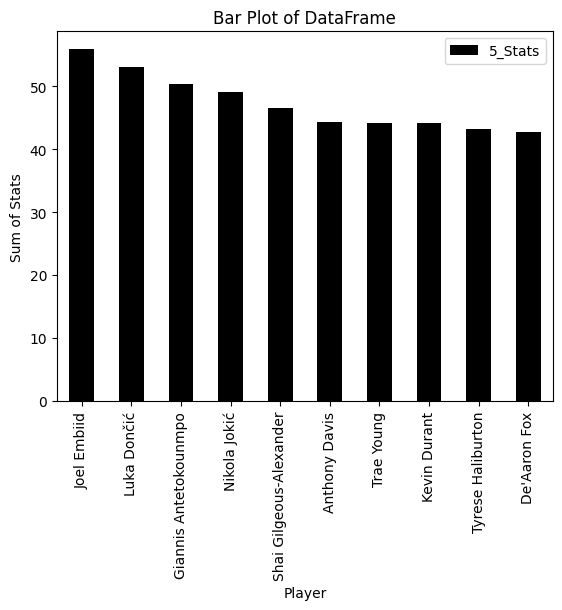

In [22]:
all_around_hoopers.plot(kind='bar', x='Player', y='5_Stats', color='black')
plt.title('Bar Plot of DataFrame')
plt.xlabel('Player')
plt.ylabel('Sum of Stats')
plt.show()